Test for using actionable-recourse, provided on https://github.com/ustunb/actionable-recourse

In order to compare recourse for several similar classifiers, we use cross validation to fit several logistic regression models (Is this the right way?). In the next step, we want to check whether the flipsets generated for one of them apply also for the other classifiers.

In [26]:
import copy
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold as CVGenerator
from sklearn.model_selection import GridSearchCV
import recourse as rs
from recourse.builder import ActionSet #FIX
from recourse.flipset import Flipset #FIX
from recourse.auditor import RecourseAuditor #FIX

import data

In [4]:
url = 'https://raw.githubusercontent.com/ustunb/actionable-recourse/master/examples/paper/data/credit_processed.csv'
df = pd.read_csv(url, skipinitialspace=True)
n_data = len(df) # 30.000
#cut_factor = 0.1 # 1 -> full dataset considered (but randomly shuffled)
#idxs = np.random.choice(n_data, int((1-cut_factor)*n_data), replace = False)
# randomly choose cut_factor * n samples to fasten analysis
#df = df.drop(idxs)
y, X = df.iloc[:, 0], df.iloc[:, 1:]
print(len(df))

30000


NEW: Use Cross validation to train several different classifiers (takes some time!)

In [5]:
alter_C = True
n_splits = 20
if not alter_C:
    clf = LogisticRegression(max_iter=10000)
    cv = cross_validate(clf, X, y, cv=n_splits, return_estimator=True)
    cv_scores = cv['test_score']
    classifiers = np.array(cv['estimator'])

Alternative: Use GridSearchCV on parameter C (takes some time!)

In [6]:
if alter_C:
    cv_generator = CVGenerator(n_splits = 10)
    clf = LogisticRegression(max_iter=10000, solver='lbfgs')

    # this code is for general purpose train/test evaluation using GridSearchCV
    gridsearch = GridSearchCV(
        clf, 
        param_grid={'C':np.logspace(-4, 3, num=n_splits)},
        scoring='accuracy',
        cv=cv_generator,
        verbose=1,
        n_jobs=-1
    )

    gridsearch.fit(X,y)
    grid_search_df = pd.DataFrame(gridsearch.cv_results_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.8min finished


**TODO:** This (desirable(?)) implementation of classifiers_C is incompatible with the use for the tables below. Fix that and test if it actualy works this way!

In [40]:
if alter_C:
    # cache a model for each parameter combination, trained on all data
    classifiers = []
    classifier_Cs = []
    for idx, p in tqdm(list(grid_search_df.params.iteritems())):
        model = copy.deepcopy(clf.set_params(**p)).fit(X,y)
        classifiers.append(model)
        classifier_Cs.append(p['C'])
    cv_scores = grid_search_df['mean_test_score']
    classifiers = np.array(classifiers)
    # Is it inconsistent to consider score before fitting the whole train set? 
    # But otherwise, it would violate train-test splitting
    # CV + fit is a bit of an overkill here?

NEW: Select those classifiers that achieve performance within certain tolerance

In [8]:
#X_test = X[:3]
#for i, est in enumerate(scores['estimator']):
#    print(scores['test_score'][i], est.predict(X_test))
tolerance = 1*np.std(cv_scores)
good_classifiers = classifiers[cv_scores >= np.max(cv_scores) - tolerance]

print(np.max(cv_scores))
print(cv_scores.std())
print(len(good_classifiers))

0.8060666666666666
0.0009324557277482572
10


get predictions

In [9]:
yhat = [clf.predict(X) for clf in good_classifiers]
yhat_ = np.array(yhat, dtype=int)

NEW: Overview table for the classifiers

In [10]:
overview = pd.DataFrame()
good_Cs = [] # Collect C values of good classifiers in list; MAYDO: Already care for this when creating classifier_Cs
for i in np.flatnonzero(cv_scores >= np.max(cv_scores) - tolerance):
    for key, value in list(classifier_Cs[i]): # classifier_Cs is of type dict_items -> not subscriptable
        if key == 'C':
            good_Cs.append(value)
overview['C'] = good_Cs
overview['coeffients'] = [np.around(clf.coef_, decimals = 3)[:,:3] for clf in good_classifiers]
overview['predictions'] =  [yhat_[j_clf,np.all(np.array([np.any(yhat_, axis=0),\
                                                        np.any(np.logical_not(yhat_), axis = 0)]), axis=0)][:5] for j_clf in range(len(good_classifiers))]
overview['accuracy'] = np.array(cv_scores[cv_scores >= np.max(cv_scores) - tolerance])

print(overview.iloc[:5].to_latex())
overview

\begin{tabular}{lrllr}
\toprule
{} &         C &               coeffients &      predictions &  accuracy \\
\midrule
0 &  0.001274 &  [[-0.002, 0.096, 0.03]] &  [1, 1, 1, 1, 1] &  0.805933 \\
1 &  0.002976 &  [[0.242, 0.425, 0.143]] &  [1, 1, 1, 0, 1] &  0.806067 \\
2 &  0.206914 &   [[0.32, 0.461, 0.159]] &  [0, 0, 1, 0, 0] &  0.805533 \\
3 &  0.483293 &  [[0.356, 0.566, 0.198]] &  [1, 0, 1, 0, 1] &  0.805367 \\
4 &  1.128838 &   [[0.37, 0.582, 0.211]] &  [1, 0, 1, 0, 1] &  0.805567 \\
\bottomrule
\end{tabular}



,C,coeffients,predictions,accuracy
0,0.001274,"[[-0.002, 0.096, 0.03]]","[1, 1, 1, 1, 1]",0.805933
1,0.002976,"[[0.242, 0.425, 0.143]]","[1, 1, 1, 0, 1]",0.806067
2,0.206914,"[[0.32, 0.461, 0.159]]","[0, 0, 1, 0, 0]",0.805533
3,0.483293,"[[0.356, 0.566, 0.198]]","[1, 0, 1, 0, 1]",0.805367
4,1.128838,"[[0.37, 0.582, 0.211]]","[1, 0, 1, 0, 1]",0.805567
5,14.384499,"[[0.362, 0.573, 0.206]]","[1, 0, 1, 0, 1]",0.805567
6,33.598183,"[[0.353, 0.57, 0.204]]","[1, 0, 1, 0, 1]",0.805633
7,78.475997,"[[0.28, 0.364, 0.101]]","[0, 0, 0, 0, 0]",0.805400
8,183.298071,"[[0.386, 0.59, 0.232]]","[1, 0, 1, 0, 1]",0.805333
9,428.133240,"[[0.362, 0.58, 0.209]]","[1, 0, 1, 0, 1]",0.805600


**TODO:** Make this work!

0.8050333333333333
0.8019333333333334
[-3.999999999999999, -3.631578947368421, -3.2631578947368416, -2.894736842105263, -2.526315789473684, -2.1578947368421053, -1.789473684210526, -1.4210526315789471, -1.0526315789473686, -0.6842105263157897, -0.31578947368421056, 0.05263157894736816, 0.42105263157894685, 0.7894736842105257, 1.1578947368421053, 1.5263157894736838, 1.8947368421052626, 2.2631578947368416, 2.6315789473684204, 2.9999999999999996]
[-3.999999999999999, -3.631578947368421, -3.2631578947368416, -2.894736842105263, -2.526315789473684, -2.1578947368421053, -1.789473684210526, -1.4210526315789471, -1.0526315789473686, -0.6842105263157897, -0.31578947368421056, 0.05263157894736816, 0.42105263157894685, 0.7894736842105257, 1.1578947368421053, 1.5263157894736838, 1.8947368421052626, 2.2631578947368416, 2.6315789473684204, 2.9999999999999996]
[2.30258509e-04 3.19943161e-04 4.44559581e-04 6.17713535e-04
 8.58310173e-04 1.19261812e-03 1.65713750e-03 2.30258509e-03
 3.19943161e-03 4.44

/home/valerie/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in power
  
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


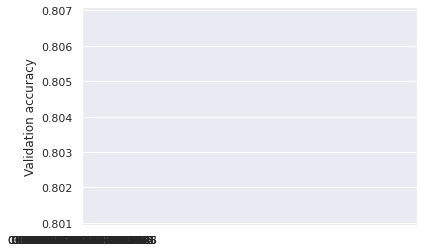

In [71]:
print(cv_scores.mean())
print(cv_scores.min())
print([np.log(d['C'])/np.log(10) for d in classifier_Cs])
print([np.log(d['C'])/np.log(10) for d in classifier_Cs])
#plt.bar([np.log(d['C'])/np.log(10) for d in classifier_Cs], cv_scores.to_numpy())
x_bar = [np.log(d['C']) for d in classifier_Cs]
x_ticks = np.logspace(-4, 3)
x_locs = np.log(10**x_ticks)
print(x_locs)
plt.bar(x_bar, cv_scores.to_numpy())
plt.ylim([cv_scores.min() - 0.001, cv_scores.max()+0.001])
plt.xticks(x_locs, x_ticks)
plt.xlabel("log C")
plt.ylabel("Validation accuracy")
plt.savefig("barplot_validation.svg")
plt.show()

In [57]:
a = np.logspace(-4, 3, num=20)
print(np.log(a))

[-9.21034037 -8.36201955 -7.51369872 -6.6653779  -5.81705708 -4.96873625
 -4.12041543 -3.27209461 -2.42377378 -1.57545296 -0.72713213  0.12118869
  0.96950951  1.81783034  2.66615116  3.51447198  4.36279281  5.21111363
  6.05943446  6.90775528]


In [11]:
yhat_[:,np.all([np.any(yhat_, axis=0),\
                np.any(np.logical_not(yhat_), axis=0)], axis=0)].shape

(10, 1168)

In [12]:
A = np.array([[True, False, True, False],[True, True, False, False]])
print(A)
B = np.array([np.any(A, axis=0), np.any(np.logical_not(A), axis = 0)])
print(B)
C = np.all(B, axis=0)
print(A[:,C])

[[ True False  True False]
 [ True  True False False]]
[[ True  True  True False]
 [False  True  True  True]]
[[False  True]
 [ True False]]


relative amount of individuals where not all classifiers predict the same

In [13]:
np.mean(np.all([np.any(yhat_, axis=0),\
        np.any(np.logical_not(yhat_), axis=0)], axis=0))

0.038933333333333334

customize the set of actions and align

In [14]:
action_sets=[]
for clf in good_classifiers:
    ## matrix of features. ActionSet will learn default bounds and step-size.
    A = ActionSet(X)
    ## specify immutable variables
    A['Married'].mutable = False 
    ## can only specify properties for multiple variables using a list
    A[['Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59', 'Age_geq_60']].mutable = False 
    A['EducationLevel'].step_direction = 1  ## force conditional immutability.
    A['EducationLevel'].step_size = 1  ## set step-size to a custom value.
    A['EducationLevel'].step_type = "absolute"  ## force conditional immutability.
    A['EducationLevel'].bounds = (0, 3)
    A['TotalMonthsOverdue'].step_size = 1  ## set step-size to a custom value.
    A['TotalMonthsOverdue'].step_type = "absolute"  ## discretize on absolute values of feature rather than percentile values
    A['TotalMonthsOverdue'].bounds = (0, 100)  ## set bounds to a custom value.
    
    ## tells `ActionSet` which directions each feature should move in to produce positive change.
    A.align(clf)
    action_sets.append(A)

print some flipset

In [15]:
%%capture
j_clf = np.random.randint(len(good_classifiers))
i = np.random.randint(len(X.iloc[np.flatnonzero(yhat[j_clf] <= 0)]))
print(j_clf, i)
fs = Flipset(x = X.iloc[np.flatnonzero(yhat[j_clf] <= 0)].to_numpy()[i,:],\
             action_set = action_sets[j_clf], clf = good_classifiers[j_clf])
fs.populate(enumeration_type = 'distinct_subsets', total_items = 10)

In [16]:
fs.to_latex()

'\\begin{tabular}{rlccc}\n\\toprule\n &               \\textsc{Feature Subset} &  \\textsc{Current Values} &               &  \\textsc{Required Values} \\\\\n0    &                  \\textit{MostRecentBillAmount} &                   8810.0 &  $\\longrightarrow$ &              2.461000e+03 \\\\\n0    &                    \\textit{TotalOverdueCounts} &                      1.0 &  $\\longrightarrow$ &              0.000000e+00 \\\\\n0    &                    \\textit{TotalMonthsOverdue} &                     16.0 &  $\\longrightarrow$ &              1.500000e+01 \\\\\n1    &          \\textit{MaxBillAmountOverLast6Months} &                   8810.0 &  $\\longrightarrow$ &              8.892000e+03 \\\\\n1    &                  \\textit{MostRecentBillAmount} &                   8810.0 &  $\\longrightarrow$ &              2.568000e+03 \\\\\n1    &                    \\textit{TotalOverdueCounts} &                      1.0 &  $\\longrightarrow$ &              0.000000e+00 \\\\\n1    &        

NEW: change inputs according to flipsets (takes some time!)

**TODO:** Use only negatively predicted datapoints; Make whole thing more sound

In [17]:
%%capture
X_new = [copy.deepcopy(X.iloc[np.flatnonzero(yhat[j_clf] <= 0)]).to_numpy() for j_clf in range(len(good_classifiers))]
# X_new[clf that generated flipset][datapoint, feature]
k_fs = 0 # k-th flipset is applied; MAYDO later: iterate k_fs?
for j_clf, clf in enumerate(good_classifiers):
    print("Apply flipsets of classifier", j_clf)
    for i in range(X_new[j_clf].shape[0]):
        fs = Flipset(x = X_new[j_clf][i, :], action_set = action_sets[j_clf], clf = clf)
        fs.populate(enumeration_type = 'distinct_subsets', total_items = k_fs+1)
        X_new[j_clf][i, fs._df['feature_idx'][k_fs]] = fs._df['x_new'][k_fs]

In [18]:
print([len(X_new[i]) for i in range(len(good_classifiers))])

[2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039]


NEW: Measure for how many individuals the adjusted input leads to desirable outcomes for each classifier

In [19]:
yhat_new = [[clf_pred.predict(X_new[j_fs]) for clf_pred in good_classifiers] \
            for j_fs in range(len(good_classifiers))] 
# yhat_new[clf that generated flipset][clf that predicted outcome][datapoint]
# the datapoint dimension has different lengths!

In [20]:
print([[len(yhat_new[i][j]) for i in range(len(good_classifiers))] for j in range(len(good_classifiers))])

[[2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039], [2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039], [2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039], [2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039], [2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039], [2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039], [2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039], [2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039], [2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039], [2572, 2884, 3139, 3020, 3020, 3050, 2995, 3263, 2992, 3039]]


In [21]:
flip_accuracy = [[yhat_new[i_fs][j_pred].mean() for j_pred in range(len(good_classifiers))] \
                 for i_fs in range(len(good_classifiers))]
# flip_accuracy[clf that generared][clf that evaluated]

Not necessary: Some example to see change

In [22]:
print(X.iloc[np.flatnonzero(yhat[0] <= 0)][:4])
print(X_new[0][:4])
for j_clf in range(len(good_classifiers)):
    print("after", yhat_new[0][j_clf][:10])
    print("befor", yhat[j_clf][np.flatnonzero(yhat[0] <= 0)][:10])

    Married  Single  Age_lt_25  Age_in_25_to_40  Age_in_40_to_59  ...  \
13        0       1          0                1                0  ...   
16        0       1          1                0                0  ...   
22        0       1          0                1                0  ...   
50        0       1          0                0                1  ...   

    MostRecentBillAmount  MostRecentPaymentAmount  TotalOverdueCounts  \
13                  2010                      100                   2   
16                   470                      100                   1   
22                  1250                       60                   2   
50                  1130                        0                   1   

    TotalMonthsOverdue  HistoryOfOverduePayments  
13                   7                         1  
16                   8                         1  
22                   8                         1  
50                   9                         1  

[4 rows x 17

Not necessary: Which features have changed, examplary for clf 0

In [23]:
print((X.iloc[np.flatnonzero(yhat[0] <= 0)]!=X_new[0]).mean(axis=0))

Married                                  0.000000
Single                                   0.000000
Age_lt_25                                0.000000
Age_in_25_to_40                          0.000000
Age_in_40_to_59                          0.000000
Age_geq_60                               0.000000
EducationLevel                           0.000000
MaxBillAmountOverLast6Months             0.288491
MaxPaymentAmountOverLast6Months          0.001944
MonthsWithZeroBalanceOverLast6Months     0.119751
MonthsWithLowSpendingOverLast6Months     0.014774
MonthsWithHighSpendingOverLast6Months    0.026050
MostRecentBillAmount                     0.153188
MostRecentPaymentAmount                  0.019051
TotalOverdueCounts                       0.069984
TotalMonthsOverdue                       0.940124
HistoryOfOverduePayments                 0.000000
dtype: float64


Inspect flip robustness **TODO:** Inspect non-1 diag value

In [85]:
flip_robustness = np.asarray(flip_accuracy)
flip_robustness.shape
print(np.diag(flip_robustness))

fr_no_diag = np.asarray([np.delete(fa, i) for i, fa in enumerate(flip_accuracy)])
print(fr_no_diag.shape)
print(fr_no_diag.argmax())
print(fr_no_diag.argmin())
print(fr_no_diag.mean())
print(fr_no_diag.std())

print(fr_no_diag[int(50/9), 50%9])

[1.         1.         1.         1.         1.         1.
 1.         0.99969353 1.         1.        ]
(10, 9)
50
33
0.6168283176620234
0.10247768735734966
0.9019672131147541


Plot some figures.

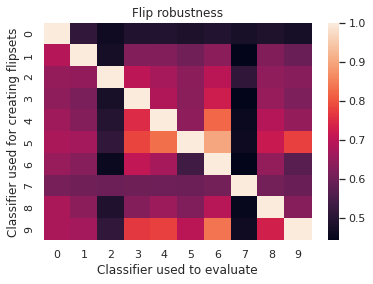

In [27]:
# graphisch reprsentieren?
import seaborn as sns
sns.set()
sns.heatmap(flip_accuracy)
plt.title("Flip robustness")
plt.xlabel("Classifier used to evaluate")
plt.ylabel("Classifier used for creating flipsets")
plt.savefig("heatmap_flip_accuracy.svg")

In [28]:
print(flip_accuracy[0])

[1.0, 0.5143856920684292, 0.46578538102643857, 0.4918351477449456, 0.4937791601866252, 0.48405909797822705, 0.4941679626749611, 0.47900466562986005, 0.48716951788491447, 0.4770606531881804]


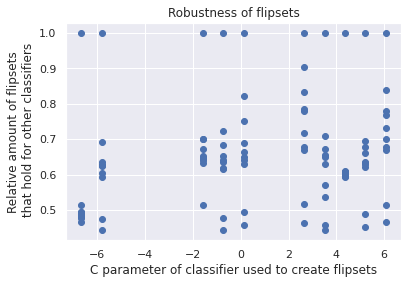

In [29]:
import matplotlib.pyplot as plt
x_scatter = np.repeat([np.log(x) for x in good_Cs], len(good_classifiers))
plt.scatter(x_scatter, np.array(flip_accuracy).flatten())
plt.title("Robustness of flipsets")
plt.xlabel("C parameter of classifier used to create flipsets")
plt.ylabel("Relative amount of flipsets\n that hold for other classifiers")
plt.savefig("scatter_flip_accuracy.svg")

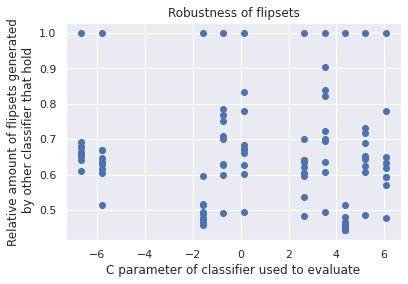

In [30]:
x_scatter = np.tile([np.log(x) for x in good_Cs], len(good_classifiers))
plt.scatter(x_scatter, np.array(flip_accuracy).flatten())
plt.title("Robustness of flipsets")
plt.xlabel("C parameter of classifier used to evaluate")
plt.ylabel("Relative amount of flipsets generated\n by other classifier that hold")
plt.savefig("scatter_flip_accuracy_by_clf_pred.svg")

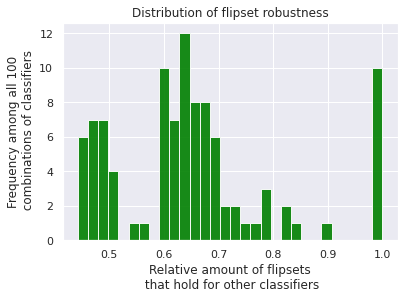

In [31]:
plt.hist(np.array(flip_accuracy).flatten(), bins=30, density=False, histtype='bar', facecolor = 'green', alpha = 0.9)
plt.title("Distribution of flipset robustness")
plt.xlabel("Relative amount of flipsets\n that hold for other classifiers")
plt.ylabel("Frequency among all " + str(len(good_classifiers)**2) + "\n combinations of classifiers")
plt.savefig("histogram_flip_accuracy.svg")
plt.show()

**TODO!:** Why are flipsets not perfect, i. e. diagonal of flip_accuracy has enties < 1??!!

In [32]:
print([flip_accuracy[i][i] for i in range(len(good_classifiers))])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9996935335580754, 1.0, 1.0]


Run Recourse Audit for each classifier on Training Data (Takes some time!)

In [99]:
recourse_feasibilities = []
recourse_costs = []
recourse_cost_stds = []
for j, clf in enumerate(good_classifiers):
    auditor = RecourseAuditor(action_sets[j], coefficients = clf.coef_[0], intercept = clf.intercept_[0])
    audit_df = auditor.audit(X)  ## matrix of features over which we will perform the audit.
    recourse_feasibilities.append(audit_df['feasible'].mean())
    recourse_costs.append(audit_df['cost'].mean())
    recourse_cost_stds.append(audit_df['cost'].std())

In [87]:
recourse_costs_ = np.asarray(recourse_costs)
print(recourse_costs_.min())
print(recourse_costs_.max())
print(recourse_costs_.mean())
print(recourse_costs_.std())

0.044664908386575296
0.0520456491795402
0.04629356411897387
0.0020639459762727373


In [103]:
# in dataframe speichern
results = pd.DataFrame(data={})#'i_clf': np.arange(len(good_classifiers))})
results['C'] = good_Cs
results['CV_accuracy'] = np.asarray(cv_scores)[cv_scores >= np.max(cv_scores) - tolerance]
results['y=0 frequency'] = [np.mean(yhat[i] < 1) for i in range(len(good_classifiers))]
results['feasibility'] = recourse_feasibilities
results['cost_mean'] = recourse_costs
results['cost_std'] = recourse_cost_stds
results['fr_generating'] = flip_accuracy
results['fr_evaluating'] = [[flip_accuracy[i_fs][j_pred] for i_fs in range(len(good_classifiers))]\
                           for j_pred in range(len(good_classifiers))] #flip_accuracy.T


In [104]:
results['fr_generating_mean'] = [np.mean(results['fr_generating'][i]) for i in range(len(results))]
results['fr_generating_std'] = [np.std(results['fr_generating'][i]) for i in range(len(results))]
results['fr_evaluating_mean'] = [np.mean(results['fr_evaluating'][i]) for i in range(len(results))]
results['fr_evaluating_std'] = [np.std(results['fr_evaluating'][i]) for i in range(len(results))]

In [108]:
results = results.drop(['fr_generating','fr_evaluating'], axis=1)

In [109]:
print(results.to_latex(index=True))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &           C &  CV\_accuracy &  y=0 frequency &  feasibility &  cost\_mean &  cost\_std &  fr\_generating\_mean &  fr\_generating\_std &  fr\_evaluating\_mean &  fr\_evaluating\_std \\
\midrule
0 &    0.001274 &     0.805933 &       0.085733 &          1.0 &   0.044665 &  0.023185 &            0.538725 &           0.154242 &            0.694874 &           0.104023 \\
1 &    0.002976 &     0.806067 &       0.096133 &          1.0 &   0.046043 &  0.025427 &            0.632108 &           0.142000 &            0.661756 &           0.120241 \\
2 &    0.206914 &     0.805533 &       0.104633 &          1.0 &   0.047656 &  0.026791 &            0.680185 &           0.117420 &            0.548556 &           0.154994 \\
3 &    0.483293 &     0.805367 &       0.100667 &          1.0 &   0.045214 &  0.025487 &            0.649073 &           0.142912 &            0.705751 &           0.129740 \\
4 &    1.128838 &     0.805567 &       0.100667 &       